<div class="usecase-title">Small Area Population Growth & Active Transport Needs Analysis</div>

<div class="usecase-authors"><b>Authored by: </b>Angie Hollingworth and Mick Wiedermann</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<div class="usecase-section-header">Scenario</div>

- As a future resident of Melbourne, I want to live close to active and/or public transport routes. I prefer not to use my car in and around the city, where shall I live?
- As a city council, we wish to increase the sustainability of our city and reduce the number of motor vehicles coming and going to lower emissions. What infrastructure investment will help achieve this goal?
- As a city council, we wish to see our highest areas of active and/or public transport to identify where we could increase services for our residents


<div class="usecase-section-header">Exploratory Data Analysis Objectives</div>

The goals for this analysis (Part A) are: 
- Analyse population growth at the suburb level to quantify the speed of growth of each suburb relative to one another.   
- Analyse the existing active transportation routes’ current demand and access relative to the forecast growth of the population.  
- Identify key areas where active transportation routes could experience higher demand therefore may require additional infrastructure. 

Population Growth & Public Transport Needs Analysis (Part B) will extend this analysis and include public transport, trams, buses, and trains.  


<div class="usecase-section-header">Strategic Benefits for the City of Melbourne</div>

This use case and analysis in conjunction with Part B, can help Melbourne City meet strategic and sustainability goals in the following ways: 
- Support discussions with infrastructure-related partners for the location of new or upgraded, public and active transportation routes to reduce the use of motorised vehicles in turn reducing emissions helping to meet the climate and biodiversity emergency objective.
- Encouraging additional purpose-designed bike paths in heavy use areas can remove bicycles from the road and reduce the number of bike-related injuries helping to meet the safety and well-being objective. 
- Identify areas of higher active transport traffic (foot/bicycle etc) in comparison with predicted population growth to establish a use-case for more resources to encourage a greater use of active transport paths and or bike lanes 


<div class="usecase-section-header">Why Inner-City Transport Routes Matter </div>

Melbourne City is the first in Australia to make a [Voluntary Local Review (VLR) Declaration](https://www.melbourne.vic.gov.au/about-council/vision-goals/Pages/united-nations-sustainable-development-goals.aspx) which is a United Nations initiative for local and regional governments worldwide to formally commit to and report their local progress toward the seventeen Sustainable Development Goals.

By examining the active and public transport routes and usage within Melbourne City, in conjunction with the population growth forecasts, we hope to identify areas with existing and projected increased demand for additional active and public transport routes. 

The hope is that by ensuring that the appropriate sustainable transport options are available and easily accessible, we would discourage the use of motorised vehicles within Melbourne City reducing emissions while creating a more sustainable city.   

This will help Melbourne City to achieve two of the UN sustainability goals namely sustainable cities and communities, and climate action, along with a key strategic objective, the [climate and biodiversity emergency](https://www.melbourne.vic.gov.au/about-council/vision-goals/Pages/council-plan.aspx) objective which prioritises the reduction of emissions.

<div class="usecase-section-header">Data Requirments</div>

## Melbourne Open Data Datasets
### Population Growth Forecast Data
Our first and arguably the most important dataset for this analysis is the [*City of Melbourne Population Forecasts by Small Area 2021-2041*](https://data.melbourne.vic.gov.au/People/City-of-Melbourne-Population-Forecasts-by-Small-Ar/sp4r-xphj) from Melbourne Open Data which provides population forecasts by single year for 2021 to 2041. Prepared by SGS Economics and Planning (Jan-Jun 2021), forecasts are available for the municipality and small areas, as well as by gender and 5-year age groups.

### Super Tuesday Bike Count data
To understand the current volume of cyclists on bike paths, we can use the [*Annual Bike Counts (Super Tuesday)*](https://data.melbourne.vic.gov.au/Transport/Annual-Bike-Counts-Super-Tuesday-/uyp8-7ii8)) dataset. In summary, the dataset contains observed bike counts from sites across the city and is part of Australia’s biggest annual commuter bike path count dataset. Later datasets for Super Tuesday include greater information about the types of bike path user (walker, bike rider, gender etc)

### Bike Path Geospatial data
For this analysis we are looking solely at the Active transport routes. For a visual representation of the bike paths/routes, we require geospatial data. The following dataset [*Bicycle routes, including informal, on-road and off-road routes*](https://data.melbourne.vic.gov.au/Transport/Bicycle-routes-including-informal-on-road-and-off-/24aw-nd3i) contains information about each of the paths along with the geospatial data. 

## Other Datasets
### Victorian Suburbs Geospatial Data
In order to visualise our population forecasts as a map overlay, we need the geographical coordinates of the suburbs we'll be examining. For this we'll use the *VIC Suburb/Locality Boundaries - PSMA Administrative Boundaries GeoJSON* dataset from the Australian Government site [data.gov.au](https://data.gov.au/dataset/ds-dga-af33dd8c-0534-4e18-9245-fc64440f742e/distribution/dist-dga-d467c550-fdf0-480f-85ca-79a6a30b700b/details?q=). 


<div class="usecase-section-header">Importing the data</div>

Before importing our datasets, we shall first import the necessary libraries to support our exploratory data analysis and visualisation.

The following are the special packages required for this analysis:
- GeoPandas: An extension of the Pandas library with the ability to handle geospatial data. 
- Folium: A library that enables interactive map visualisations in Python. 
- Shapely: A Python package for geometric spatial analysis.

In [34]:
# !pip install mapclassify

In [35]:
# For importing the data and using API
# from sodapy import Socrata
from urllib.request import urlopen
import os
import zipfile as zf
import requests
from io import BytesIO 

# Working with the data
from shapely.geometry import Polygon, Point
import numpy as np
import pandas as pd
import geopandas as gpd
import json

# Visualisation
from IPython.display import IFrame, display, HTML
import matplotlib.pylab as plt
import seaborn as sns
import warnings
import folium
from folium import plugins
from folium.plugins import HeatMap

# Turn off warnings for report purposes (enable for debugging)
warnings.filterwarnings('ignore')

The API connection to the Melbourne Open Data Portal changed right before finsihing this report. As such, we are using the direct JSON file download rather than the API.

For API use, an application access token can be requested from the City of Melbourne Open Data portal by registering [here](https://data.melbourne.vic.gov.au).

For all of our below examples, we have switched to using the download link for the JSON files for each dataset (rather than the API), which can be found under the "Export" section for each dataset in the above linked url's.


The *City of Melbourne Population Forecasts by Small Area 2021-2041* dataset which can be found [here](https://data.melbourne.vic.gov.au/explore/dataset/city-of-melbourne-population-forecasts-by-small-area-2020-2040/information/)

In [36]:
# We have used the download link for the JSON file.
pop_url = 'https://data.melbourne.vic.gov.au/explore/dataset/city-of-melbourne-population-forecasts-by-small-area-2020-2040/download/?format=json&timezone=Australia/Sydney&lang=en'

# Get the JSON data using requests.get(), then converted it to a JSON file.
pop_data_json = requests.get(pop_url).json()

# The JSON object is then converted to a pandas data frame.
pop_data_json_df = pd.DataFrame.from_dict(pop_data_json)

pop_data_json_df.head()

,datasetid,recordid,fields,record_timestamp
0,city-of-melbourne-population-forecasts-by-smal...,3a2b4fa4da7c26ae39cc0ac3cdc40c6d2ef9dc61,"{'geography': 'City of Melbourne', 'year': '20...",2022-12-13T22:54:44.509+11:00
1,city-of-melbourne-population-forecasts-by-smal...,74bfcf8c6bc4ac337436bfee156a74b26ebf18b3,"{'geography': 'City of Melbourne', 'year': '20...",2022-12-13T22:54:44.509+11:00
2,city-of-melbourne-population-forecasts-by-smal...,22c11ad417902fe2151e21bae5225604698a88fb,"{'geography': 'City of Melbourne', 'year': '20...",2022-12-13T22:54:44.509+11:00
3,city-of-melbourne-population-forecasts-by-smal...,79711237bc7e639f9da7b165c733bfcb936ef30e,"{'geography': 'City of Melbourne', 'year': '20...",2022-12-13T22:54:44.509+11:00
4,city-of-melbourne-population-forecasts-by-smal...,0b593d951a71a08ed6ecfbc2fbcccf7068a67b38,"{'geography': 'City of Melbourne', 'year': '20...",2022-12-13T22:54:44.509+11:00


The only column we are interested in is the 'fields' column. So let grab that column and format it into another table

In [37]:
# Create a blank array to hold all of our row data.
pop_rows = []

# Iterate through the 'fields' column.
for row in pop_data_json_df['fields']:
    # Add the row data to our array as a list.
    pop_rows.extend([[a for a in row.values()]])

# Create our Population Forecast Dataframe, using the key values as our column headers.
population_data = pd.DataFrame(pop_rows, columns = [i for i in pop_data_json_df['fields'][0].keys()])

#View our output.
population_data.tail()

,geography,year,age,value,gender
17047,West Melbourne (Industrial),2040,Total population,0,Not applicable
17048,West Melbourne (Industrial),2041,Total population,0,Not applicable
17049,West Melbourne (Residential),2024,Total population,8345,Not applicable
17050,West Melbourne (Residential),2031,Total population,12716,Not applicable
17051,West Melbourne (Residential),2040,Total population,14824,Not applicable


Next, we’ll use the same approach to import the remaining datasets described above from the Melbourne Open Data Portal. 

In [38]:
# Bike Path Geographical Data
bike_path_url = 'https://data.melbourne.vic.gov.au/explore/dataset/bicycle-routes-including-informal-on-road-and-off-road-routes/download/?format=geojson&timezone=Australia/Sydney&lang=en'

#We only require a JSON file, so no further formatting is required
BIKE_PATHS = requests.get(bike_path_url).json()    

In [39]:
# Bike Count Data
bike_url = 'https://data.melbourne.vic.gov.au/explore/dataset/annual-bike-counts-super-tuesday/download/?format=json&timezone=Australia/Sydney&lang=en'
bike_data_json = requests.get(bike_url).json()
bike_data_json_df = pd.DataFrame.from_dict(bike_data_json)

# This dataset is missing a large amount of values, so we will specifically look for 
# the columns we require for our analysis.
cols = ['latitude','longitude','total','year', 'description']

# create an empty list to hold our row values.
bike_rows = []
for i, row in enumerate(bike_data_json_df['fields']):
    # Get the data that is specifically in the above columns. If it is missing, replace with None.
    d = [row.get(cols[j]) or None for j in range(len(cols))]
    bike_rows.extend([d])

# Bike useage counts.
BIKE_USAGE_COUNT = pd.DataFrame(bike_rows, columns = cols)
# View the output.
BIKE_USAGE_COUNT.head()

,latitude,longitude,total,year,description
0,-37.793993,144.941956,20,2010,"Melrose St [N], Melrose St [S], Mark St [W]"
1,-37.794540,144.930987,233,2010,"Macaulay Rd - east end [E], Eastwood St [S], M..."
2,-37.796627,144.951172,435,2010,"Gatehouse St [NE], Flemington Rd [SE], Harker ..."
3,-37.808903,144.966278,437,2010,"La Trobe St [E], Russell St (city) [S], La Tro..."
4,-37.809547,144.975632,880,2010,"Gisborne St [N], Albert St [E], Gisborne St [S..."


The last Dataset we need to import is the *Victorian Suburbs/Locality Boundaries* from the Australian Government site, data.gov.au, which is freely available for download via the below URL. As the data includes geometric data, we will also import this data into a GeoPandas dataframe.

In [40]:
# Suburb Geographical Data.
suburb_geo_data_url = ('https://data.gov.au/geoserver/vic-suburb-locality-boundaries-psma-administrative-'
    + 'boundaries/wfs?request=GetFeature&typeName=ckan_af33dd8c_0534_4e18_9245_fc64440f742e&outputFormat=json')

vic_suburb_data = gpd.read_file(suburb_geo_data_url)
VIC_SUBURBS = vic_suburb_data[['vic_loca_2', 'geometry']]
VIC_SUBURBS = VIC_SUBURBS.rename(columns={'vic_loca_2':'suburb'})

VIC_SUBURBS.head()

,suburb,geometry
0,UNDERBOOL,"MULTIPOLYGON (((141.74552 -35.07229, 141.74552..."
1,NURRAN,"MULTIPOLYGON (((148.66877 -37.39571, 148.66876..."
2,WOORNDOO,"MULTIPOLYGON (((142.92288 -37.97886, 142.90449..."
3,DEPTFORD,"MULTIPOLYGON (((147.82336 -37.66001, 147.82313..."
4,YANAC,"MULTIPOLYGON (((141.27978 -35.99859, 141.27989..."


<div class="usecase-section-header">Cleaning and Preparing Our Data</div>

As we know from reading the data descriptions and dictionaries from each of the datasets, most have data that we don’t require. In this section, we will extract the data we need and join various sets ready for analysis. 

### Population Forecast and Suburb Geospatial Data
Starting with the population and suburb geospatial data, we need to remove suburbs from the geospatial data that are not included in our population forecast data. Also, we need to match the City of Melbourne suburbs by name which require a merge of certain fields and renaming of others. 

By passing the population dataset to the following two functions, we can clean the dataset to return only the columns (information) that we require whilst also formatting the column names and data types. The second function will return a new data frame with either the population totals by suburb for the year specified or all years if the boolean parameter is set to true.   

In [41]:
def prepare_pop_data(dataset):
    """
    Filters and cleans the Population dataset returning a new pandas dataframe.
    
        dataset: The City of Melbourne Population Forecasts by Small Area 2021-2041. 
    """
    # Excluding the population totals & average age.
    dataset = dataset.loc[dataset['gender'] == 'Total']
    dataset = dataset.loc[dataset['age'] != 'Average age']
    
    # Extract the colomns of interest into "summary" and rename geography.
    summary = dataset[['geography', 'year', 'value', 'age']]
    summary = summary.rename(columns={'geography':'suburb'})
    
    # Convert datatypes
    summary = summary.astype({'year':int, 'value':float, 'suburb':'string'})

    # Consolidating and updating suburb names to match the Geospatial data.
    summary['suburb'] = summary['suburb'].replace(['Melbourne (CBD)', 'Melbourne (Remainder)'], ['Melbourne', 'Melbourne'])
    summary['suburb'] = summary['suburb'].replace(['West Melbourne (Residential)'], ['West Melbourne'])
    
    # Removing unrequired data.  
    summary.drop(summary.index[summary['suburb'] == 'West Melbourne (Industrial)'], inplace=True)
    summary.drop(summary.index[summary['suburb'] == 'City of Melbourne'], inplace=True)
    summary.drop(summary.index[summary['suburb'] == 'Port Melbourne'], inplace=True)
    
    # Sorting the data and resetting the indexes.
    summary.sort_values(['suburb'], inplace = True)
    summary = summary.reset_index(drop=True)
    '''
    n.b Port Melbourne Population count is very small and doesn't seem to be acurate. 
        This jumps in subsequent years skewing the data,for that reason we have chosen 
        to exclude port melbourne from the analisys. 
    Melbourne (Remainder) and Melbourne (CBD) were combined to match the Geospatial data.
    '''
    summary = gpd.GeoDataFrame(summary)

    return summary

In [42]:
# Clean the initial dataset to contain only the information we require.
POPULATION_DATA = prepare_pop_data(population_data)

POPULATION_DATA.head()

,suburb,year,value,age
0,Carlton,2021,1769.0,Age 30-34
1,Carlton,2024,43.0,Age 85+
2,Carlton,2025,597.0,Age 0-4
3,Carlton,2025,1798.0,Age 15-19
4,Carlton,2025,3636.0,Age 25-29


In [43]:
def population_by_year(grouped_data, year, all_years=False):
    """
    Returns Geo DataFrame of the population by suburb of the year specified or all years if set to True.
    
        dataset: The prepared "POPULATION_DATA" dataset. 
        year:    The desired year for the population totals.
        all_years (bool, optional): If True, will return a summary of all years.
    """
    grouped_data = grouped_data[['suburb', 'year', 'value']]
    
    if all_years:
        grouped_data = grouped_data.groupby(['suburb', 'year'])['value'].sum()
        grouped_data = grouped_data.reset_index()
    else:
        grouped_data = grouped_data.loc[grouped_data['year'] == year]
        grouped_data = grouped_data.groupby(['suburb', 'year'])['value'].sum()
        grouped_data = grouped_data.reset_index()
        grouped_data = grouped_data.rename(columns={'value': str(year)})
        grouped_data = grouped_data.drop(columns=['year'])
        grouped_data = grouped_data.astype({'suburb':'string'})
    
    grouped_data = gpd.GeoDataFrame(grouped_data)
    
    return grouped_data


In [44]:
# Reducing the dataset size with the pop_data_by_year function above.
population_2022 = population_by_year(POPULATION_DATA, 2022)

population_2022

,suburb,2022
0,Carlton,17630.0
1,Docklands,16221.0
2,East Melbourne,5092.0
3,Kensington,11117.0
4,Melbourne,47781.0
5,North Melbourne,15938.0
6,Parkville,7920.0
7,South Yarra,3786.0
8,Southbank,22998.0
9,West Melbourne,8078.0


Next, we’ll utilise our reduced dataset above to filter and extract the suburbs of interest from the geospatial data. 

In [45]:
# Extract the suburbs of interest that match the population_data into "target_suburbs".
target_subs = population_2022['suburb'].str.upper()

# Locate the index of the target suburbs and store as a list in "subs".
subs = [VIC_SUBURBS.index[VIC_SUBURBS['suburb']==sub].tolist()[0] for sub in target_subs]

#Remove unwanted rows and keep data in geo dataframe format.
CITY_SUBURBS = VIC_SUBURBS.take(list(subs))
CITY_SUBURBS.reset_index(drop=True, inplace = True)
CITY_SUBURBS['suburb'] = CITY_SUBURBS['suburb'].str.title()
CITY_SUBURBS = CITY_SUBURBS.astype({'suburb':'string'}) 

CITY_SUBURBS

,suburb,geometry
0,Carlton,"MULTIPOLYGON (((144.97401 -37.80311, 144.97320..."
1,Docklands,"MULTIPOLYGON (((144.95376 -37.82363, 144.95336..."
2,East Melbourne,"MULTIPOLYGON (((144.97136 -37.80773, 144.97308..."
3,Kensington,"MULTIPOLYGON (((144.92282 -37.79913, 144.91977..."
4,Melbourne,"MULTIPOLYGON (((144.97797 -37.83867, 144.97803..."
5,North Melbourne,"MULTIPOLYGON (((144.95599 -37.80588, 144.95360..."
6,Parkville,"MULTIPOLYGON (((144.96521 -37.79315, 144.96460..."
7,South Yarra,"MULTIPOLYGON (((145.00455 -37.84131, 145.00453..."
8,Southbank,"MULTIPOLYGON (((144.97041 -37.83016, 144.97030..."
9,West Melbourne,"MULTIPOLYGON (((144.91648 -37.79826, 144.91754..."


This DataFrame now only includes suburbs found in our population dataset and their geospatial data (suburb outline). These two datasets can now be combined and used together in the analysis.  

### Bike Count and Path Geospatial Data  

A quick preview of our bike data shows that we have far more attributes (columns) than required. Let's extract the columns of interest for the most recent year and remove any NaN fields. Further, we need to update the data types for the extracted columns and combine the latitude and longitude into a single column containing a Point object which we’ll call geometry.  

In [46]:
# View the output from the bike_count dataset that we imported earlier.

BIKE_USAGE_COUNT.head(1)

,latitude,longitude,total,year,description
0,-37.793993,144.941956,20,2010,"Melrose St [N], Melrose St [S], Mark St [W]"


In [47]:
# Convert our bike count data frame to a GeoDataFram to be used for mapping.
bike_usage_data =  gpd.GeoDataFrame(BIKE_USAGE_COUNT)

# Drop missing data.
bike_usage_data.dropna(inplace=True)   

# Get a list of years that the bike counts were completed. Convert values to an integer data type. 
years = [int(x) for x in bike_usage_data['year'].unique()]

# Extracting the most recent year of data.
bike_usage_data = bike_usage_data.loc[bike_usage_data['year'] == str(max(years))]

# Updating the data types.
degs = ['latitude','longitude']

for col in degs:
    bike_usage_data[col] = bike_usage_data[col].astype(float)
bike_usage_data['total'] = bike_usage_data['total'].astype(int)
bike_usage_data.reset_index(drop=True, inplace = True)

# Combine the latitude & longitude values to a GeoPandas Point object in a new column for mapping.
df_geometry = [Point(xy) for xy in zip(bike_usage_data['latitude'], bike_usage_data['longitude'])]

# Create a GeoPandasDataFrame with the above cleaned dataset.
BIKE_USAGE_DATA = gpd.GeoDataFrame(bike_usage_data, crs = 4326, geometry = df_geometry)

BIKE_USAGE_DATA.head()

,latitude,longitude,total,year,description,geometry
0,-37.825963,144.960053,249,2017,"Queens Bridge St [N], City Rd [NE], Morray St ...",POINT (-37.82596 144.96005)
1,-37.793993,144.941956,42,2017,"Melrose St [N], Melrose St [S], Mark St [W]",POINT (-37.79399 144.94196)
2,-37.794117,144.927689,114,2017,"McCracken St [N], Macaulay Rd [E], Kensington ...",POINT (-37.79412 144.92769)
3,-37.795096,144.935852,1192,2017,"Upstream direction [N], Macaulay Rd [E], Moone...",POINT (-37.79510 144.93585)
4,-37.799747,144.957474,1307,2017,"Royal Pde [N], Grattan St [E], Royal Pde (city...",POINT (-37.79975 144.95747)


Finally, the bike path data is contained within a dictionary rather than a Pandas DataFrame. In this instance the dataset only contains relevant fields, so we have nothing to remove.  

In [48]:
# Viewing the attributes of the bike path data we imported earlier.  

print(BIKE_PATHS.keys())
BIKE_PATHS['features'][0]['properties'].keys()

dict_keys(['type', 'features'])


dict_keys(['geo_point_2d', 'direction', 'type', 'name'])

<div class="usecase-section-header">Analysing Our Datasets</div>

## Population Growth Analysis
To begin our analysis, we'll first take a look at the population forecast data in five-year intervals. We will utilise our population by year function to build a new data frame and then plot the data as a clustered bar chart.

First, let's confirm the first and last year contained within the population forecast dataset. 

In [49]:
# Select the earliest and latest years for the population forecast in our dataset.
start_year = min(POPULATION_DATA['year'])
final_year = max(POPULATION_DATA['year'])

# In this case we expect it to be 2021 and 2041. Let's print to confirm.
print(f'Earliest year: {start_year},  Latest year: {final_year}' )

Earliest year: 2021,  Latest year: 2041


Next, we'll extract a summary for the first year and every fifth year thereafter to create a new dataframe for our clustered bar chart. 

In [50]:
# Extracting each year of interest.
population_start = population_by_year(POPULATION_DATA, start_year)
population_2026 = population_by_year(POPULATION_DATA, 2026)
population_2031 = population_by_year(POPULATION_DATA, 2031)
population_2036 = population_by_year(POPULATION_DATA, 2036)
population_final = population_by_year(POPULATION_DATA, final_year)

# Combining the years into a single dataframe.
population_5y_intervals = population_start.merge(population_2026, left_on='suburb', right_on='suburb')
population_5y_intervals = population_5y_intervals.merge(population_2031, left_on='suburb', right_on='suburb')
population_5y_intervals = population_5y_intervals.merge(population_2036, left_on='suburb', right_on='suburb')
population_5y_intervals = population_5y_intervals.merge(population_final, left_on='suburb', right_on='suburb')

# Converting the dataframe to a GeoPandas dataframe. 
population_5y_intervals = gpd.GeoDataFrame(population_5y_intervals)
population_5y_intervals.head()

,suburb,2021,2026,2031,2036,2041
0,Carlton,17185.0,20745.0,26374.0,33358.0,35878.0
1,Docklands,15926.0,19998.0,25292.0,28781.0,32430.0
2,East Melbourne,4965.0,6204.0,7445.0,7948.0,8032.0
3,Kensington,10932.0,12940.0,15846.0,17093.0,17653.0
4,Melbourne,46946.0,59179.0,74981.0,85236.0,94002.0


Now we can generate our clustered bar chart and take our first visual representation of the data.

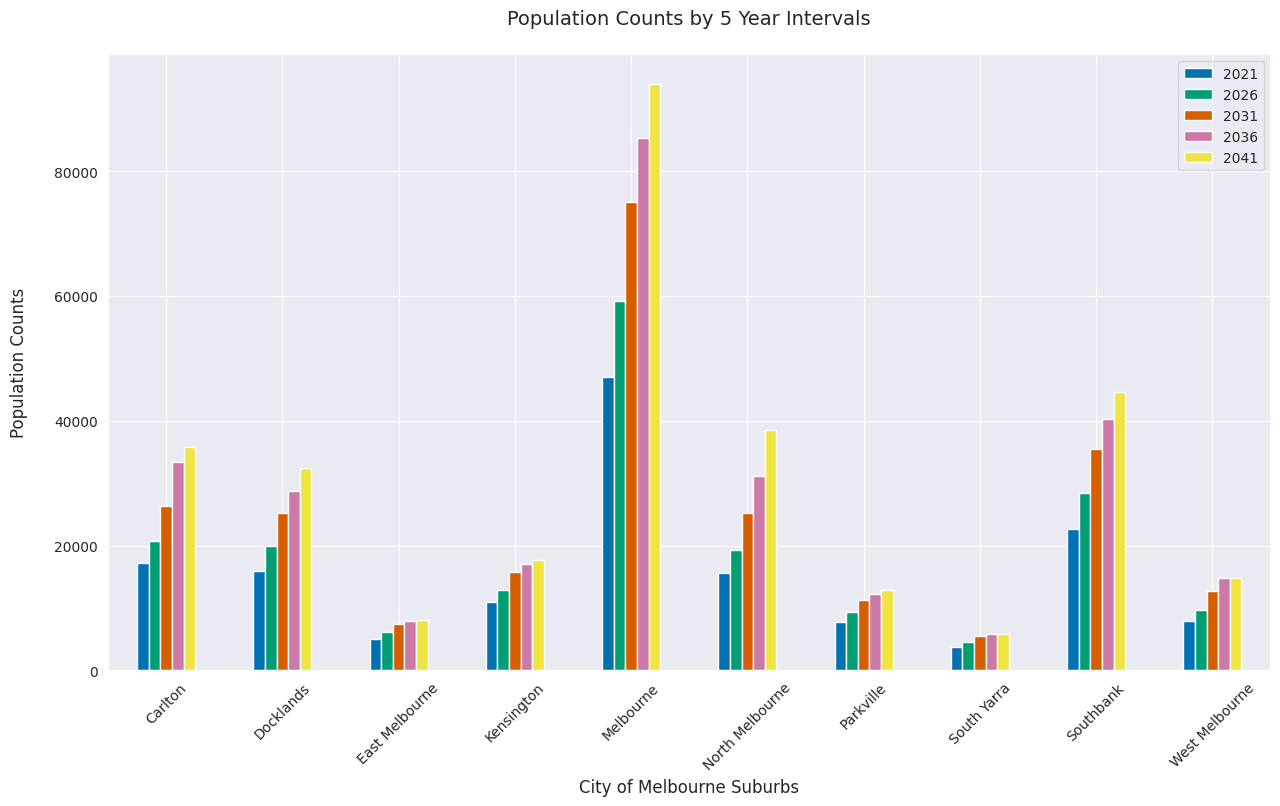

In [51]:
sns.set_style('darkgrid')
ax = population_5y_intervals.plot(x= 'suburb', kind='bar', stacked=False, figsize = (15,8))
plt.style.use('seaborn-colorblind')
ax.set_xticklabels(population_5y_intervals.suburb, rotation=45)
plt.title('Population Counts by 5 Year Intervals\n', size=14)
plt.ylabel('Population Counts\n', size=12)
plt.xlabel('City of Melbourne Suburbs', size=12)
ax.plot();

Examining the bar chart, we can see the concentration of Melbourne City's population is contained within the central suburb of Melbourne itself, which also includes the CBD. Most suburbs show quite a steep growth forecast apart from East Melbourne and South Yarra which seem quite flat in comparison.   

Let's take a closer look at each or the suburbs forecast population change from the first to the last year included in the dataset so we can better see the change relative to one another. 

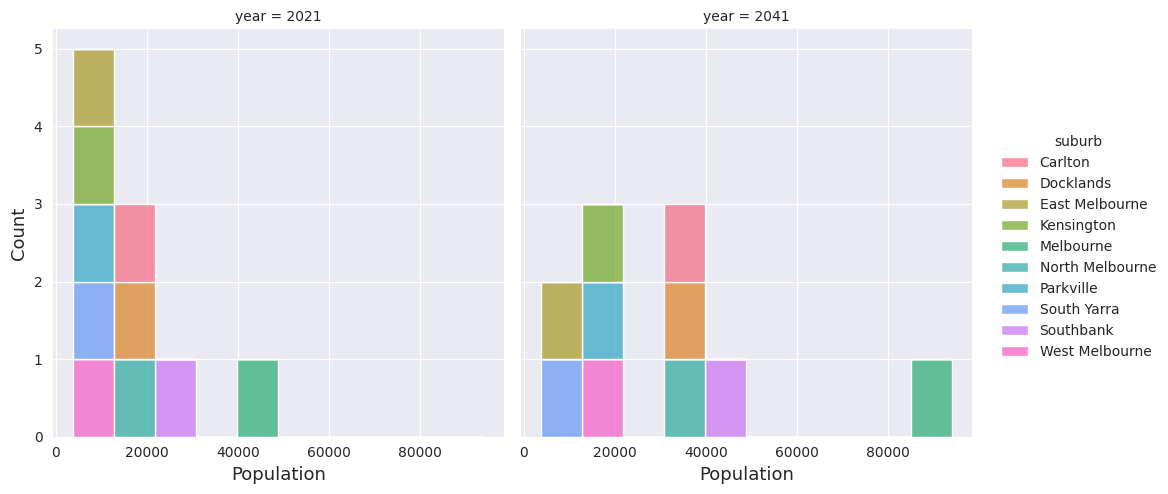

In [52]:
# Extracting a summary of our population data using the "population_by_year" function. 
population_all = population_by_year(POPULATION_DATA, start_year, True)

# Limiting the extraction to the first and last years as defined above.
population_21_41 = population_all.loc[population_all['year'].isin([start_year, final_year])]

# Finaly, plotting the distribution of the two years as a comparison. 
pop_dist = sns.displot(population_21_41, x='value', bins=10, hue='suburb', multiple='stack', col='year')
pop_dist.set_axis_labels('Population', 'Count', size=13);


Here we can clearly see the population for South Yarra and East Melbourne having minimal growth, both remaining under 10,000 residents while suburbs such as Melbourne, Southbank, North Melbourne, Docklands and Carlton, leaping ahead with what looks like a doubling of their populations.  

Let’s see how this change looks overlayed on a map of Melbourne City. We can use a choropleth map to visualise the change between each suburb to determine if the forecast growth is taking place in a cluster or sporadically across Melbourne City. 

The following function will return a GeoPandas DataFrame with our population and suburb geospatial datasets joined with the population for the two years passed and the difference between the two years as both a number and percentage. We can then plot the change between any two given years as a number or percentage. 

In [53]:
def population_change(population_df, suburbs_df, year_1, year_2):
    """
    Returns Geo DataFrame of the population by suburb of the years specified along
    with the growth as a number and a percentage between the two years.
    
        population_df:   The prepared "POPULATION_DATA" dataframe. 
        suburbs_df:      The prepared "CITY_SUBURBS" dataframe.
        year_1 & year_2: The years of interest.
    """
    # Utilising the "population_by_year" function to prepare a dataframe for each year of interest.
    start_year = population_by_year(population_df, year_1)
    end_year = population_by_year(population_df, year_2)

    # Join our above two dataframes based on "suburb".
    combined =  start_year.merge(end_year, left_on='suburb', right_on='suburb')    
    
    # calculate % and # of changes within the two years for each suburb.
    combined['growth #'] = combined[list(end_year)[1]] - combined[list(start_year)[1]]
    combined['growth %'] = round((combined[list(combined)[3]] / combined[list(start_year)[1]])*100,2)
    
    # Add the geometry (for mapping) from our CITY_SUBURBS dataframe.
    combined['geometry'] = suburbs_df['geometry']
    
    # Convert our standard pandas dataframe to a GeoPandas data frame for map rendering.
    combined = gpd.GeoDataFrame(combined)

    return combined

In [54]:
# Looking at the total growth between the start_year and final_year.
pop_diff_2021_2041 = population_change(POPULATION_DATA, CITY_SUBURBS, start_year, final_year)

# Display the head for the new Data Frame with changes in population growth.
pop_diff_2021_2041

,suburb,2021,2041,growth #,growth %,geometry
0,Carlton,17185.0,35878.0,18693.0,108.78,"MULTIPOLYGON (((144.97401 -37.80311, 144.97320..."
1,Docklands,15926.0,32430.0,16504.0,103.63,"MULTIPOLYGON (((144.95376 -37.82363, 144.95336..."
2,East Melbourne,4965.0,8032.0,3067.0,61.77,"MULTIPOLYGON (((144.97136 -37.80773, 144.97308..."
3,Kensington,10932.0,17653.0,6721.0,61.48,"MULTIPOLYGON (((144.92282 -37.79913, 144.91977..."
4,Melbourne,46946.0,94002.0,47056.0,100.23,"MULTIPOLYGON (((144.97797 -37.83867, 144.97803..."
5,North Melbourne,15653.0,38470.0,22817.0,145.77,"MULTIPOLYGON (((144.95599 -37.80588, 144.95360..."
6,Parkville,7813.0,12906.0,5093.0,65.19,"MULTIPOLYGON (((144.96521 -37.79315, 144.96460..."
7,South Yarra,3717.0,5780.0,2063.0,55.50,"MULTIPOLYGON (((145.00455 -37.84131, 145.00453..."
8,Southbank,22588.0,44605.0,22017.0,97.47,"MULTIPOLYGON (((144.97041 -37.83016, 144.97030..."
9,West Melbourne,7934.0,14814.0,6880.0,86.72,"MULTIPOLYGON (((144.91648 -37.79826, 144.91754..."


Now we have a dataframe that captures the total growth, let’s look at the change as a choropleth map.

In [57]:
pop_diff_2021_2041.explore()

In [58]:
pop_change_20y = pop_diff_2021_2041.explore(column ='growth %', 
    tiles='CartoDB positron', zoom_start=13, cmap='winter')

# Display our map.
pop_change_20y

Examining the map above we can clearly see North Melbourne will outpace all others over the period captured by the data. The next question that comes to mind is if this forecast growth is consistent across all years. Lets’ look at the change at each 5-year interval, to see if the growth rate matches the above choropleth map.  

To do this we'll write two small functions, one to return the map as above, and a second to allow us to examine the maps side by side. 

### Visualising Multiple Years of Change

Mapping the change with a folium map layer.

In [59]:
def growth_map(population_data, title = "Melbourne City", zoom = 12): 
    """
    Returns a choropleth folium map layer.
        population_data:   A prepared dataframe returned from "population_change". 
        title:  Optional - The title of the growth map. Default = Melbourne City.
        zoom:   Optional - The prefered starting zoom. Default = 12.
    """
    geo_layer = population_data.explore(column ='growth %', tiles='CartoDB positron', 
                                        cmap='winter', name = title, zoom_start=zoom)
    folium.LayerControl().add_to(geo_layer)
    
    return geo_layer 

Generating a HTML frame to contain two maps in one visualisation for ease of comparison. 

In [60]:
def create_html_comparison_maps(map_1, map_2):
    """
    Returns an iframe object to display both maps passed side by side for ease of comparison.
        map_1 & map_2: Map layers prepared with the "growth_map" function. 
    """
    htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 49%; margin: 0 auto; border: 2px solid #0f9295"></iframe>'
       '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 49%; margin: 0 auto; border: 2px solid #0f9295"></iframe>'
       .format(map_1.get_root().render().replace('"', '&quot;'),400,400,
               map_2.get_root().render().replace('"', '&quot;'),400,400))

    return (htmlmap) 

Let's create some 5-year buckets to compare the rate of population growth.

In [61]:
# Preparing our dataframe with the "population_change" function. 
pop_change_1 = population_change(POPULATION_DATA, CITY_SUBURBS, 2021, 2026)

# Create our map layer using our new function above.
map_2021_2026 = growth_map(pop_change_1, title = 'Population growth 2021-2026')

# Repeating the above to capture the entire dataset.
pop_change_2 = population_change(POPULATION_DATA, CITY_SUBURBS, 2026, 2031) 
map_2026_2031 = growth_map(pop_change_2, title = 'Population growth 2026-2031')

pop_change_3 = population_change(POPULATION_DATA, CITY_SUBURBS, 2031, 2036) 
map_2031_2036 = growth_map(pop_change_3, title = 'Population growth 2031-2036')

pop_change_4 = population_change(POPULATION_DATA, CITY_SUBURBS, 2036, 2041) 
map_2036_2041 = growth_map(pop_change_4, title = 'Population growth 2036-2041')

In [62]:
# Create our two map comparison HTML elements.
growth_5y_10y = create_html_comparison_maps(map_2021_2026, map_2026_2031)
growth_15y_20y = create_html_comparison_maps(map_2031_2036, map_2036_2041)

In [63]:
# Let's view our maps side by side.
display(growth_5y_10y)

In the above maps we can see that the highest % of growth is initially within the inner suburbs, Melbourne CBD, Southbank, Docklands, East Melbourne all at around 25% increase in population over a 5-year period. 

However, after a 10-year period we can see that that increase shifts Northwest to West Melbourne and North Melbourne with around a 30% increase in population. 

We can also see that the population growth in South Yarra is beginning to slow from 24% to 18%. 

In [64]:
display(growth_15y_20y)

Looking ahead at the next 10-year buckets, we can see that South Yarra population growth not only comes to an almost halt for the 2031-2036 period but is predicted to decline by 2041 (in comparison to 2036). 
  
North Melbourne remains a steady state of predicted increase at around 25% throughout the above 10-year period. 

Carlton drops from 27% growth, to 25% then down to less than 8% predicted growth. 
  
There is enough change in the predicted growth rates above, for us to have one more look at our 20-year period of growth. 

In [65]:
# Create the same maps as our above datasets.
pop_change_5 = population_change(POPULATION_DATA, CITY_SUBURBS, 2021, 2041) 
map_2021_2041 = growth_map(pop_change_5, title = 'Population Difference (2021 - 2041)', zoom=13)

In [66]:
# View the map
display(map_2021_2041)

As we saw in the prior four 5-year buckets, we can confirm that North Melbourne is predicted to have the highest increase in population growth at around 145% on the population totals in 2021. 

The initial inner cities that we saw with the initial population growth increases are all next in line at around a 100% increase (or double) in the residents of those suburbs. 

## Active Transport Analysis

With our initial population growth analysis complete we can now move onto the active transport analysis. Here we're looking for relationships between the forecast population growth of a suburb and the active transport routes and usage. 

In [67]:
# Revisiting our bike data, lets have a look at what we have.
print('Bike path usage:')
print(BIKE_USAGE_DATA.keys(), type(BIKE_USAGE_DATA))

print('\nBike paths:')
print(BIKE_PATHS.keys(), type(BIKE_PATHS))

Bike path usage:
Index(['latitude', 'longitude', 'total', 'year', 'description', 'geometry'], dtype='object') <class 'geopandas.geodataframe.GeoDataFrame'>

Bike paths:
dict_keys(['type', 'features']) <class 'dict'>


In [68]:
# Having another look at bike usage, we can see that this has a lat, long pair for mapping.
BIKE_USAGE_DATA.head()

,latitude,longitude,total,year,description,geometry
0,-37.825963,144.960053,249,2017,"Queens Bridge St [N], City Rd [NE], Morray St ...",POINT (-37.82596 144.96005)
1,-37.793993,144.941956,42,2017,"Melrose St [N], Melrose St [S], Mark St [W]",POINT (-37.79399 144.94196)
2,-37.794117,144.927689,114,2017,"McCracken St [N], Macaulay Rd [E], Kensington ...",POINT (-37.79412 144.92769)
3,-37.795096,144.935852,1192,2017,"Upstream direction [N], Macaulay Rd [E], Moone...",POINT (-37.79510 144.93585)
4,-37.799747,144.957474,1307,2017,"Royal Pde [N], Grattan St [E], Royal Pde (city...",POINT (-37.79975 144.95747)


In [69]:
# Our bike path data is in JSON format, so it doesn't print in a table. 
# We can see that we have a collection of lat,long pairs which make a path (features, geometry, coordinates).
print(BIKE_PATHS['features'][0].keys())
print(BIKE_PATHS['features'][0]['type'])
print(BIKE_PATHS['features'][0]['properties'])
print(BIKE_PATHS['features'][0]['geometry'].keys())
print(BIKE_PATHS['features'][0]['geometry']['type'], BIKE_PATHS['features'][0]['geometry']['coordinates'][0][:2])

dict_keys(['type', 'geometry', 'properties'])
Feature
{'geo_point_2d': [-37.79222994900859, 144.94940742049585], 'direction': 'Both Directions', 'type': 'Off-Road Bike Route', 'name': 'Off-Road Bike Route'}
dict_keys(['coordinates', 'type'])
MultiLineString [[144.951780451295, -37.790231531464], [144.951594183988, -37.790102536172]]


To visualise this data, we need to be able to combine them so that we can see where the usage counts took place along the bike routes. First, let’s examine each type of bike path so we can add each as a separate layer on our map. The following function will do just that. 

In [70]:
def get_bike_path_types(bike_paths):
    #Create an empty list to store our bike path types.
    bike_paths_types = []

    # Iterate through the bike path data and look at features.
    for feature in bike_paths['features']:

        # Set the route feature type to a variable.
        r_type = feature['properties']['type']

        # check if the type is already in the list of unique featers (bike_paths_types).
        if bike_paths_types.count(r_type) == 0:

            # Add unique path type to list.
            bike_paths_types.append(feature['properties']['type'])
    
    return  bike_paths_types

In [71]:
bike_path_type_list = get_bike_path_types(BIKE_PATHS)

#let's look at the output.
print(bike_path_type_list)

['Off-Road Bike Route', 'On-Road Bike Lane', 'Informal Bike Route', 'Corridor']


Now we know what we’re looking for, lets create a function that will take the bike path JSON file, and return a map layer for each type of bike path in the dataset (using the above function to get the list). 

In [72]:
def create_map_layer_with_path_features(bike_routes):    
    '''Create Folium map layers with the different bike path types'''
    
    # We can use the above function to get a list of route types.
    bike_paths_types = get_bike_path_types(bike_routes)
    
    # Create a list of hex colours to match our theme that has enough values for all of our path types.
    colours = ['#056b8a', '#14a38e', '#2af598', '#08b3e5', '#08af64'] 
    
    # Create an empty list to hold our map layers for each path type.
    map_routes = []
    
    # Loop through the bike path types (from above).
    for i, route_type in enumerate(bike_paths_types): # We use enumerate to get the value and index of the loop.
        
        # create a copy of the bike path json dataset
        route_json = bike_routes.copy()
        
        # remove any features (bike routes) that do not match the route type for the loop
        route_json['features'] = [path for path in route_json['features'] if path['properties']['type'] == route_type]
        
        # Add colour property to dataset.
        # for each feature in the new json file, add a __colour property and add the colour value [i].
        for data in route_json['features']:
            data['properties']['__colour'] = colours[i]
        
        # create the folium map layer for this route type.
        g = folium.GeoJson(
                    route_json,# Our copy of our bike route data for this one path type.
                    name=f'{route_type}',     
            
                    # This is a lambda function for Folium that applies the colour label to each feature.
                    style_function=lambda x:{ 
                        "color": x["properties"]["__colour"],
                        "fillColor": x["properties"]["__colour"],}, 
            
                    # Add some features to popup when you hover over a point on the map
                    tooltip=folium.features.GeoJsonTooltip(fields=['name','direction','type'])# ,'notes'.
                    )
        
        # add the map layer to the list of layers
        map_routes.extend([g])
        
    return map_routes

In [73]:
bike_map_route_layers = create_map_layer_with_path_features(BIKE_PATHS)

In [74]:
# View the output from the above function, we can see we get a list of folium features (layers) for our map.
bike_map_route_layers

Now that we have our bike path map layers, we need to create a map that has both the bike routes, and the usage counts so that we can visualise where people are mostly using the bike paths. 

In [75]:
def draw_heatMap(data, bikepath, city_map, colour = 'blue'):
    '''Function for creating a Folium map with layers for the two bike datasets'''
    
    # Create a base map layer with our city map.
    m =  city_map.explore(name = 'Melbourne City Suburbs',
                          style_kwds = dict(color= '#003300', fillOpacity = 0.2, weight = 2), zoom_start=13)
    
    #call the above function to create the coloured bike path layers.
    bike_routes = create_map_layer_with_path_features(bikepath) 
    # Add each bike path type map layer to our base map.
    for r in bike_routes:
        r.add_to(m)
        
    # Create Bike count heat map layer - this will allow us to see hot spots for usage.
    labels = data['description']
    
    #Convert data to list for heat map rendering.
    data = list(map(list, zip(data['latitude'], data['longitude'],data['total'])))        
    # Add our formatted data as a heat map layer to our base map.
    HeatMap(data, name='Bike Counts').add_to(m)
    
    # Create markers with the bike count data so we can see what the "heat" relates to.
    for i, location in enumerate(data):
        # From our table view above we know that [0] and [1] are our latitude and longitude values.
        folium.Marker(location=[location[0], location[1]],
                      popup=f'<strong>{labels[i]}</strong>',
                      tooltip=f'Bike Count: {location[2]}',
                      # create an empty icon so that our map isn't cluttered.
                      icon = folium.DivIcon(html =f"""<div style="color: {colour};">  </div>""")
                     ).add_to(m)
        
    # Add layer control to switch on and off map features.
    folium.LayerControl().add_to(m)
    
    return m # Map with layers.

We'll use the above draw_heatMap function to combine both datasets into a single visualisation.  

In [76]:
# Create a map object.
bike_map = draw_heatMap(BIKE_USAGE_DATA,BIKE_PATHS, CITY_SUBURBS, colour = 'green')

In [77]:
# Visualise our data in a map.
bike_map

Here we can see each of the bike path types as a different colour overlayed on the bike count heat map. At a glance, we can see that Melbourne the suburb has the most activity with some of that activity spilling into East Melbourne and Carlton. The next most obvious hot spot is in North Melbourne. All of these suburbs, except for East Melbourne, have been identified as our fastest growing suburbs so we can expect the activity in the areas to only increase.  

Let's bring back our final forecasted population growth map over the entire period our dataset captures so that we can better compare to the active routes to the population growth. 

In [78]:
bike_population_maps = create_html_comparison_maps(bike_map, map_2021_2041)

In [79]:
bike_population_maps

Looking at our two maps, we can clearly see the hot spots align almost perfectly with the suburbs that have the highest projected growth. Interestingly, the highest bike count occurs at the intersection of an on-road and informal bike path in Melbourne which may be worth further investigation to upgrade that informal route.  

From our metadata (or data description) of our bike counts, we know that these values were counted within a 2-hour window which infers that there (at times) are over 1,000 people riding bikes through and around the fastest growing suburb being North Melbourne. Not every bike user will have passed by every count station, so that number is most likely significantly higher. Another area for further investigation. 

<div class="usecase-section-header">Findings and Opportunities</div>

This Exploratory Data Analysis (EDA) has provided insight into both the projected growth of Melbourne's inner suburbs and bike path usage in and around those suburbs. We have been able to identify a few key points of interest where high population growth meets high bike path usage which is only set to increase.  

Further analysis from our team will be extended to include public transportation data with a similar approach to this EDA. The two studies can then be combined for a more in-depth analysis of transport within the City of Melbourne that is not motorised. 

### Broader Observations and Future Opportunities
We have seen within the above use case that there is a definite overlap in the analysis of the two datasets. This EDA can be used as an indicative analysis to support future development of Active Transportation needs within the City of Melbourne. 

Both the main datasets used, Population Growth and Bike Counts (Super Tuesday), have many more datapoints than what we have explored within this short use case. Points for further exploration and analysis could include: 

* Age brackets with the suburb populations
    * Average age is also a feature of the dataset
* Types of bike path users
    * Bicycles
    * Pedestrians
* Observed gender
* Time of day
    * The counts were taken over a two hour window
* Bike path directions
    * This can be used to see how traffic is flowing through the city
* Super Sunday
    * This dataset can be used as a comparison between weekdays and weekends
* Other years and not just the final year to look at a trend of bike path usage
* Assess if more formal bike routes should be upgraded

These points could allow an analyst to provide a much more detailed picture of what is happening within City of Melbourne suburbs, the usage and need for Active Transport facilities and further investment. 